In [1]:
import sys
sys.path.append("..")

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import numpy as np
import pandas as pd
from typing import List
from tabulate import tabulate
from dataclasses import dataclass, field
import matplotlib.pyplot as plt

# Trainer
from src.trainer.trainer import Trainer

# Models
from src.models.chA_p4_cnn import A_Ch_P4CNN
from src.models.spA_p4_cnn import A_Sp_P4CNN
from src.models.fA_p4_allcnn import fA_P4AllCNNC
from src.models.big_cnn import B15_P4CNN, B11_P4CNN

# Data Utils
from src.datasets.rot_mnist_dataset import get_dataset

## rot-MNIST dataset

In [2]:
train_loader, val_loader, test_loader = get_dataset(batch_size=128, num_workers=2)

Rotated MNIST already prepared.


Image shape: torch.Size([1, 28, 28])
Squeezed shape: (28, 28)


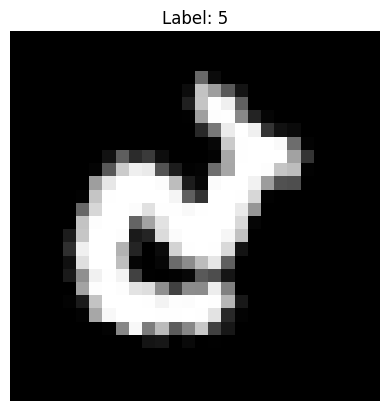

In [3]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

print("Image shape:", images[0].shape)  
image = images[0].squeeze().cpu().numpy()  
print("Squeezed shape:", image.shape)  

# Plot
plt.imshow(image, cmap='gray')
plt.title(f"Label: {labels[0].item()}")
plt.axis('off')
plt.show()


## Experiment

In [4]:
# ----- Helper Functions -----
def init_model(name):
    if name == "big15_p4_cnn":
        return B15_P4CNN()
    if name == "chA_p4_cnn":
        return A_Ch_P4CNN()
    elif name == "spA_p4_cnn":
        return A_Sp_P4CNN()
    elif name == "big11_p4_cnn":
        return B11_P4CNN()
    elif name == "fA_p4_allcnn":
        return fA_P4AllCNNC()
    else:
        raise ValueError(f"Unknown model name: {name}")

def init_optimizer(model, lr, weight_decay):
    return optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

def init_scheduler(optimizer, milestones):
    return optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 250, 300], gamma=0.1)

# ----- Helper Classes -----
@dataclass
class HyperParams:
    lr: float
    epochs: int
    weight_decay: float
    momentum: float
    gamma: float
    milestones: List[int] = field(default_factory=list)

In [5]:
# ----- Configuration -----
num_iterations = 3
log_dir = "../logs"

model_hyperparameters = {
    "big15_p4_cnn":  HyperParams(lr=0.001, epochs=100, weight_decay=0.0001, momentum=0.9, milestones=[200, 250, 300], gamma=0.1),
    "chA_p4_cnn":  HyperParams(lr=0.001, epochs=100, weight_decay=0.0001, momentum=0.9, milestones=[200, 250, 300], gamma=0.1),
    "spA_p4_cnn": HyperParams(lr=0.001, epochs=100, weight_decay=0.0001, momentum=0.9, milestones=[200, 250, 300], gamma=0.1),
    "big11_p4_cnn":  HyperParams(lr=0.001, epochs=100, weight_decay=0.0001, momentum=0.9, milestones=[200, 250, 300], gamma=0.1),
    "fA_p4_allcnn": HyperParams(lr=0.001, epochs=100, weight_decay=0.0001, momentum=0.9, milestones=[200, 250, 300], gamma=0.1)
}
model_names = model_hyperparameters.keys()
accuracies = {name: [] for name in model_names}

In [6]:
# ----- Main Training Loop -----
for it in range(num_iterations):
    print(f"Iteration {it + 1}/{num_iterations}")

    for name in model_names:
        print(f"\n→ Training model: {name}")

        # 1. Grab hyperparams for this model
        hp = model_hyperparameters[name]

        # 2. Initialize model, criterion, optimizer, scheduler
        model = init_model(name)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(
            model.parameters(),
            lr=hp.lr,
            momentum=hp.momentum,
            weight_decay=hp.weight_decay
        )
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=hp.milestones,
            gamma=hp.gamma
        )

        # 3. Wrap in our Trainer (single‐model)
        trainer = Trainer(
            models={name: model},
            optimizers=[optimizer],
            criterions=[criterion],
            schedulers=[scheduler],
            log_dir=f"{log_dir}/{name}"
        )

        # 4. Train & validate with the model‐specific epoch count
        trainer.train(
            num_epochs=hp.epochs,
            train_loader=train_loader,
            val_loader=val_loader,
        )

        # 5. Evaluate on test set and record accuracy
        test_acc = trainer.evaluate(test_loader=test_loader)[name]
        accuracies[name].append(test_acc)

Iteration 1/3

→ Training model: big15_p4_cnn
Using device: cuda
Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Training model : big15_p4_cnn


Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.05it/s, Train Acc=0.7797, Val Acc=0.1045, Train Loss=0.7100, Val Loss=49.0688]



→ Training model: chA_p4_cnn
Using device: cuda
Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Training model : chA_p4_cnn


Training Epochs: 100%|████████████████████████████████████████████████████████████████| 100/100 [12:26<00:00,  7.46s/it, Train Acc=0.9284, Val Acc=0.1085, Train Loss=0.2169, Val Loss=5.4928]



→ Training model: spA_p4_cnn
Using device: cuda
Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Training model : spA_p4_cnn


Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [14:17<00:00,  8.58s/it, Train Acc=0.9355, Val Acc=0.1045, Train Loss=0.2002, Val Loss=11.6627]



→ Training model: big11_p4_cnn
Using device: cuda
Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Training model : big11_p4_cnn


Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s, Train Acc=0.9385, Val Acc=0.1045, Train Loss=0.1890, Val Loss=13.6430]



→ Training model: fA_p4_allcnn
Using device: cuda
Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Training model : fA_p4_allcnn


Training Epochs: 100%|████████████████████████████████████████████████████████████████| 100/100 [15:10<00:00,  9.11s/it, Train Acc=0.9961, Val Acc=0.3625, Train Loss=0.1457, Val Loss=2.0457]


Iteration 2/3

→ Training model: big15_p4_cnn
Using device: cuda
Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Training model : big15_p4_cnn


Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s, Train Acc=0.8336, Val Acc=0.1045, Train Loss=0.5247, Val Loss=29.7184]



→ Training model: chA_p4_cnn
Using device: cuda
Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Training model : chA_p4_cnn


Training Epochs: 100%|████████████████████████████████████████████████████████████████| 100/100 [12:22<00:00,  7.43s/it, Train Acc=0.9324, Val Acc=0.1045, Train Loss=0.2194, Val Loss=9.7999]



→ Training model: spA_p4_cnn
Using device: cuda
Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Training model : spA_p4_cnn


Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [14:17<00:00,  8.57s/it, Train Acc=0.9404, Val Acc=0.1045, Train Loss=0.1889, Val Loss=14.9389]



→ Training model: big11_p4_cnn
Using device: cuda
Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Training model : big11_p4_cnn


Training Epochs: 100%|████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s, Train Acc=0.9376, Val Acc=0.2945, Train Loss=0.1968, Val Loss=3.4361]



→ Training model: fA_p4_allcnn
Using device: cuda
Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Training model : fA_p4_allcnn


Training Epochs: 100%|████████████████████████████████████████████████████████████████| 100/100 [15:10<00:00,  9.10s/it, Train Acc=0.9954, Val Acc=0.2555, Train Loss=0.1533, Val Loss=2.5125]


Iteration 3/3

→ Training model: big15_p4_cnn
Using device: cuda
Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Training model : big15_p4_cnn


Training Epochs: 100%|████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s, Train Acc=0.8169, Val Acc=0.3690, Train Loss=0.5865, Val Loss=3.0712]



→ Training model: chA_p4_cnn
Using device: cuda
Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Training model : chA_p4_cnn


Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [12:31<00:00,  7.51s/it, Train Acc=0.9303, Val Acc=0.1045, Train Loss=0.2167, Val Loss=11.4171]



→ Training model: spA_p4_cnn
Using device: cuda
Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Training model : spA_p4_cnn


Training Epochs: 100%|████████████████████████████████████████████████████████████████| 100/100 [14:34<00:00,  8.74s/it, Train Acc=0.9356, Val Acc=0.4490, Train Loss=0.2030, Val Loss=2.4517]



→ Training model: big11_p4_cnn
Using device: cuda
Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Training model : big11_p4_cnn


Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s, Train Acc=0.9325, Val Acc=0.1045, Train Loss=0.2075, Val Loss=12.2635]



→ Training model: fA_p4_allcnn
Using device: cuda
Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Training model : fA_p4_allcnn


Training Epochs: 100%|████████████████████████████████████████████████████████████████| 100/100 [15:16<00:00,  9.16s/it, Train Acc=0.9965, Val Acc=0.4250, Train Loss=0.1304, Val Loss=1.9206]


In [7]:
# ----- Final Statistics -----
final_stats = {
    name: {
        "% Test error": (1 - float(np.mean(vals))) * 100,
        "% std": float(np.std(vals)) * 100,
        "Num Parameters": sum(p.numel() for p in init_model(name).parameters())
    }
    for name, vals in accuracies.items()
}

## Table generation

In [8]:
df = pd.DataFrame.from_dict(final_stats, orient='index')
df = df.round(2)
print("📊 Model Accuracy Summary in CIFAR10\n")
print(tabulate(df, headers="keys", tablefmt="fancy_grid"))

📊 Model Accuracy Summary in CIFAR10

╒══════════════╤════════════════╤═════════╤══════════════════╕
│              │   % Test error │   % std │   Num Parameters │
╞══════════════╪════════════════╪═════════╪══════════════════╡
│ big15_p4_cnn │          38.6  │   15.25 │  42710           │
├──────────────┼────────────────┼─────────┼──────────────────┤
│ chA_p4_cnn   │           5.13 │    0.05 │  45830           │
├──────────────┼────────────────┼─────────┼──────────────────┤
│ spA_p4_cnn   │           4.88 │    0.19 │  46310           │
├──────────────┼────────────────┼─────────┼──────────────────┤
│ big11_p4_cnn │           5.78 │    1.75 │  24610           │
├──────────────┼────────────────┼─────────┼──────────────────┤
│ fA_p4_allcnn │           3.4  │    0.48 │      1.40012e+06 │
╘══════════════╧════════════════╧═════════╧══════════════════╛
